In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [26]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [27]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [30]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for i in measurement_columns:
    print(i['name'], i['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [31]:
station_columns = inspector.get_columns('station')
for i in station_columns:
    print(i['name'], i['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [33]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).\
                order_by(measurement.date.desc()).first()
print(f'The most recent date is:{recent_date[0]}')

The most recent date is:2017-08-23


In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.


previous_year_date = (dt.datetime.strptime(recent_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f'The previous year date is:{previous_year_date}')


The previous year date is:2016-08-23


In [41]:
# Perform a query to retrieve the data and precipitation scores
date_precip = (measurement.date, measurement.prcp)

precip_data = session.query(*date_precip).filter(measurement.date >= previous_year_date).all()
precip_data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [43]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precip_df = pd.DataFrame(precip_data,columns=['date', 'precipitation'])
precip_df.set_index('date',inplace=True)
precip_df = precip_df.sort_index()
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


Text(0, 0.5, 'Precipitation (Inches)')

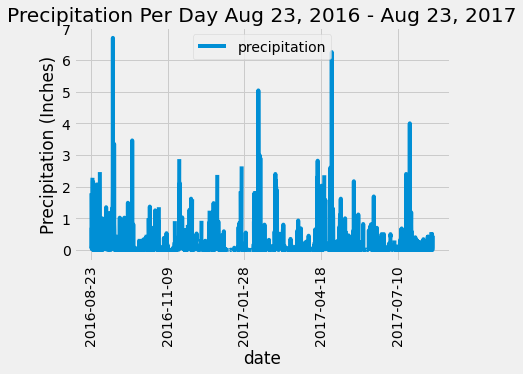

In [46]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(rot=90);
ax.set_title('Precipitation Per Day Aug 23, 2016 - Aug 23, 2017')
ax.set_ylabel('Precipitation (Inches)')

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(station.id)).all()
total_stations

[(9)]

In [49]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  group_by(measurement.station).\
                  order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [53]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
most_active_data = session.query(measurement.date,measurement.tobs).\
                   filter(measurement.station == 'USC00519281').\
                   filter(measurement.date > previous_year_date).all()
most_active_data[:10]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0)]

Text(0.5, 1.0, 'Activity at Station USC00519281')

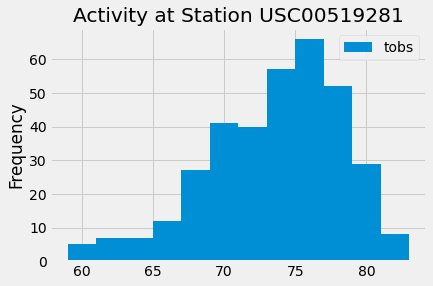

In [56]:
#plot the results as a histogram
most_active_data_df = pd.DataFrame(most_active_data)
USC00519281_hist = most_active_data_df.plot(kind='hist',bins=12)
USC00519281_hist.set_title('Activity at Station USC00519281')

# Close session

In [57]:
# Close Session
session.close()